# **Önleyici Sağlık Politikaları İçin Bir Araç: Diyabet Hastalarında Tekrar Yatış Riskinin Tahmini**

### **Problem Tanımı**

Hastaneye tekrar yatışlar (readmissions), sağlık sistemleri üzerinde hem ciddi bir finansal yük oluşturmakta hem de sunulan bakımın kalitesine dair önemli bir gösterge olarak kabul edilmektedir. Önlenebilir tekrar yatışlar, genellikle hastanın taburculuk sürecinin veya taburculuk sonrası takibinin yetersiz olduğunu gösterir.

Diyabet gibi kronik ve karmaşık bakım gerektiren hastalıklara sahip bireyler, bu açıdan daha yüksek risk altındadır. Sağlık politikası geliştiricileri ve hastane yöneticileri, hangi hastaların yüksek risk altında olduğunu önceden tespit edebilirse, kısıtlı olan sağlık kaynaklarını (örn: evde bakım hemşiresi, taburculuk sonrası telefon takibi, hasta eğitimi) bu gruba yönlendirerek hem hasta sağlığını iyileştirebilir hem de sistem maliyetlerini düşürebilirler.

### **Amaç**

Bu projenin temel amacı, sağlanan 10 yıllık diyabet hasta verisetini kullanarak, bir hastanın hastaneye tekrar yatma olasılığını tahmin eden bir makine öğrenmesi modeli geliştirmektir.

**İkincil Amaçlar:**

Tekrar yatış riskini artıran en önemli faktörleri belirlemek.

Modelin bulgularını, sağlık politikası geliştiricilerine "yüksek riskli" hasta gruarına yönelik proaktif müdahale programları tasarlamaları için kanıt-temelli bir temel olarak sunmaktır.

### **Proje Akışı**

**1.  Veri Yükleme ve Kütüphane Kurulumu:** Gerekli Python kütüphanelerinin (Pandas, Numpy, Matplotlib, Seaborn, Scikit-learn) yüklenmesi ve veri setinin Google Colab ortamına aktarılması.

**2.   Problem Çerçeveleme:** readmitted (hedef değişken) sütununun analiz edilmesi ve problemin binary sınıflandırma problemine dönüştürülmesi.


**3. Keşifsel Veri Analizi (EDA):** Veri setinin genel yapısının incelenmesi. Hedef değişkenin dağılımının incelenmesi. Nümerik ve kategorik değişkenlerin hedef değişken üzerindeki etkilerinin görselleştirilmesi.

**4. Veri Ön İşleme (Data Preprocessing):**

* Eksik Verilerin Yönetimi.

* Kategorik Değişkenlerin Dönüştürülmesi.

* Nümerik Değişkenlerin Ölçeklendirilmesi.

**5. Özellik Mühendisliği:** Mevcut değişkenlerden yeni, anlamlı değişkenler türetilmesi.

**6. Modelleme:**

* Verinin Eğitim (Train) ve Test setlerine ayrılması.

* Farklı modellerin eğitilmesi (Baseline olarak Lojistik Regresyon, performans için Random Forest/XGBoost).

**7. Model Değerlendirme:**

Metrik Seçimi: Sınıf dengesizliği nedeniyle 'Accuracy' yerine '1' (Riskli) sınıfı için Precision, Recall, F1-Score ve genel performans için ROC-AUC metriklerinin kullanılması.

Karmaşıklık Matrisi (Confusion Matrix) analizi.

**8. Model Yorumlama ve Sonuç:**

En iyi modelin seçilmesi.

Modelin kararlarını neden verdiğini anlamak için SHAP veya Feature Importance analizi yapılması.

Bulguların "Sağlık Politikası" diline çevrilmesi.


In [ ]:
# --- 1. Temel Veri Manipülasyonu ve Analizi ---
import pandas as pd
import numpy as np

# --- 2. Veri Görselleştirme ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Veri Ön İşleme (Preprocessing) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# --- 4. Sınıf Dengesizliği Yönetimi ---
from imblearn.over_sampling import SMOTE

# --- 5. Modelleme ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- 6. Model Değerlendirme (Metrikler) ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score
)

# --- 7. Model Yorumlanabilirliği ---
import shap

# --- Görselleştirme Ayarları ---
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 6))

print("Tüm kütüphaneler başarıyla yüklendi.")

Tüm kütüphaneler başarıyla yüklendi.


In [ ]:
import kagglehub
import os

print("Kaggle'dan veri seti yolu alınıyor (önbellekten)...")

# 1. Veri setinin bulunduğu klasörün yolunu alalım
path = kagglehub.dataset_download("dubradave/hospital-readmissions")

print(f"Veri seti klasörü: {path}")

# 2. DOĞRU CSV dosyasının tam yolunu oluşturalım
# Dosya adını 'hospital_readmissions.csv' olarak güncelledik
csv_file_path = os.path.join(path, 'hospital_readmissions.csv')

print(f"Okunacak dosya yolu: {csv_file_path}")

# 3. CSV dosyasını Pandas'a yükleyelim
try:
    # '?' karakterini "Eksik Veri" (NaN) olarak tanımasını söylüyoruz
    df = pd.read_csv(csv_file_path, na_values='?')

    print("\nVERİ SETİ BAŞARIYLA YÜKLENDİ.")
    print(f"Toplam {df.shape[0]} satır ve {df.shape[1]} sütun bulunuyor.")

    # 4. Verinin 'başına' bir göz atalım
    display(df.head())

except FileNotFoundError:
    print(f"\nHATA: '{csv_file_path}' yolu bulunamadı.")
except Exception as e:
    print(f"\nBir hata oluştu: {e}")

Kaggle'dan veri seti yolu alınıyor (önbellekten)...
Using Colab cache for faster access to the 'hospital-readmissions' dataset.
Veri seti klasörü: /kaggle/input/hospital-readmissions
Okunacak dosya yolu: /kaggle/input/hospital-readmissions/hospital_readmissions.csv

VERİ SETİ BAŞARIYLA YÜKLENDİ.
Toplam 25000 satır ve 17 sütun bulunuyor.


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [ ]:
# Yalnızca sayısal sütunların istatistiksel özetini al
print("\n--- Sayısal Veri Özeti (describe) ---")
display(df.describe().T)


--- Sayısal Veri Özeti (describe) ---


,count,mean,std,min,25%,50%,75%,max
time_in_hospital,25000.0,4.45332,3.001470,1.0,2.0,4.0,6.0,14.0
n_lab_procedures,25000.0,43.24076,19.818620,1.0,31.0,44.0,57.0,113.0
n_procedures,25000.0,1.35236,1.715179,0.0,0.0,1.0,2.0,6.0
n_medications,25000.0,16.25240,8.060532,1.0,11.0,15.0,20.0,79.0
n_outpatient,25000.0,0.36640,1.195478,0.0,0.0,0.0,0.0,33.0
n_inpatient,25000.0,0.61596,1.177951,0.0,0.0,0.0,1.0,15.0
n_emergency,25000.0,0.18660,0.885873,0.0,0.0,0.0,0.0,64.0


In [ ]:
# Yalnızca 'object' tipindeki (kategorik) sütunların özetini al
print("\n--- Kategorik Veri Özeti (describe) ---")
display(df.describe(include='object').T)


--- Kategorik Veri Özeti (describe) ---


,count,unique,top,freq
age,25000,6,[70-80),6837
medical_specialty,25000,7,Missing,12382
diag_1,25000,8,Circulatory,7824
diag_2,25000,8,Other,9056
diag_3,25000,8,Other,9107
glucose_test,25000,3,no,23625
A1Ctest,25000,3,no,20938
change,25000,2,no,13497
diabetes_med,25000,2,yes,19228
readmitted,25000,2,no,13246


In [ ]:
# 'object' (kategorik) tipindeki tüm sütunların isimlerini alalım
object_cols = df.select_dtypes('object').columns

print("--- Kategorik Sütunların Değer Dağılımları ---")

# Bu sütunların her birinin içinde dönelim
for col in object_cols:
    print(f"\n===== SÜTUN: {col} =====")

    # .unique() yerine .value_counts() kullanalım.
    # Bu sayede hem benzersiz değerleri GÖRÜRÜZ,
    # hem de kaçar tane olduklarını BİLİRİZ
    print(df[col].value_counts())

--- Kategorik Sütunların Değer Dağılımları ---

===== SÜTUN: age =====
age
[70-80)     6837
[60-70)     5913
[80-90)     4516
[50-60)     4452
[40-50)     2532
[90-100)     750
Name: count, dtype: int64

===== SÜTUN: medical_specialty =====
medical_specialty
Missing                   12382
InternalMedicine           3565
Other                      2664
Emergency/Trauma           1885
Family/GeneralPractice     1882
Cardiology                 1409
Surgery                    1213
Name: count, dtype: int64

===== SÜTUN: diag_1 =====
diag_1
Circulatory        7824
Other              6498
Respiratory        3680
Digestive          2329
Diabetes           1747
Injury             1666
Musculoskeletal    1252
Missing               4
Name: count, dtype: int64

===== SÜTUN: diag_2 =====
diag_2
Other              9056
Circulatory        8134
Diabetes           2906
Respiratory        2872
Digestive           973
Injury              591
Musculoskeletal     426
Missing              42
Name: count, 

In [ ]:
# 'yes' olanlar 1 (Riskli), 'no' olanlar 0 (Risksiz)
# Bu, görselleştirmelerimizde 'y' ekseni olacak.
df['target'] = (df['readmitted'] == 'yes').astype(int)

print("--- 'target' Sütunu Oluşturuldu ---")
print(df['target'].value_counts(normalize=True) * 100)

--- 'target' Sütunu Oluşturuldu ---
target
0    52.984
1    47.016
Name: proportion, dtype: float64


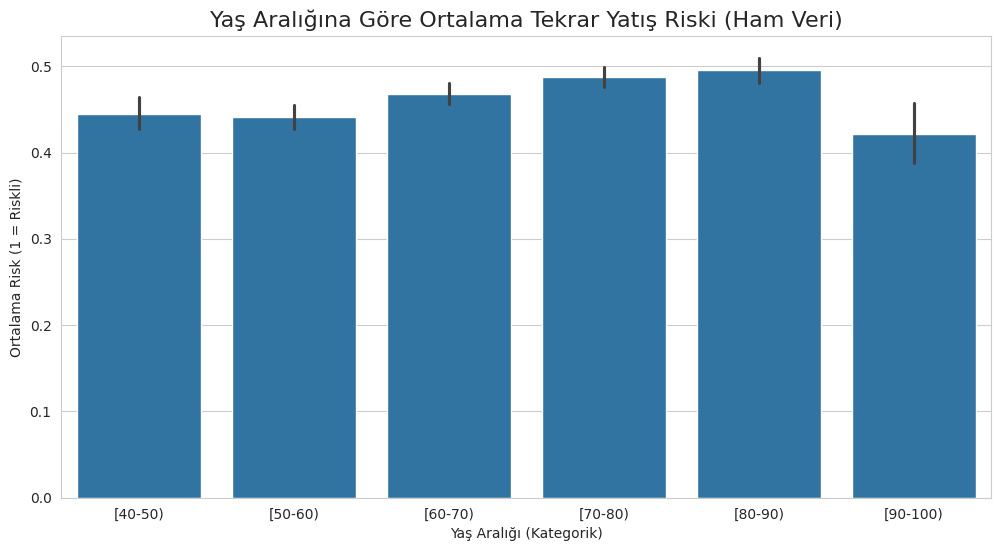

In [ ]:
# 'age' sütununu mantıklı bir sıraya koymak için (gençten yaşlıya)
age_order = sorted(df['age'].unique())

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='age', y='target', order=age_order)
plt.title('Yaş Aralığına Göre Ortalama Tekrar Yatış Riski (Ham Veri)', fontsize=16)
plt.xlabel('Yaş Aralığı (Kategorik)')
plt.ylabel('Ortalama Risk (1 = Riskli)')
plt.show()

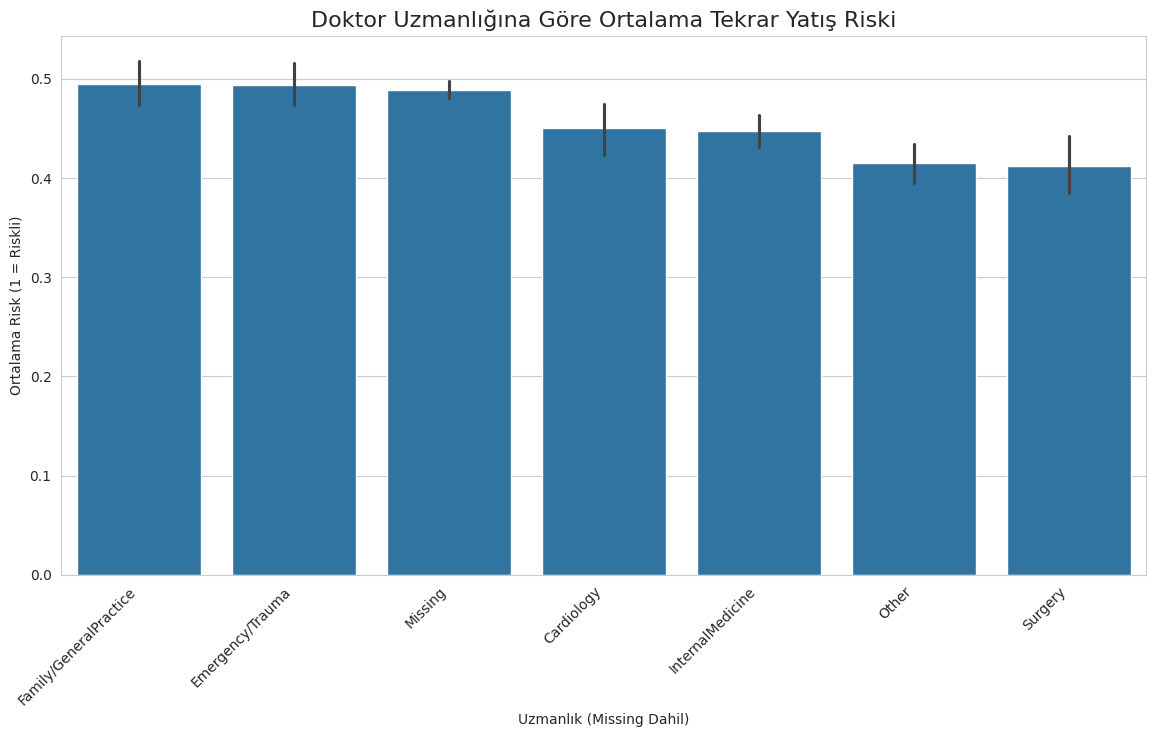

In [ ]:
plt.figure(figsize=(14, 7))
# Risk oranına göre sıralayarak daha okunaklı hale getirelim
specialty_risk = df.groupby('medical_specialty')['target'].mean().sort_values(ascending=False)

sns.barplot(data=df, x='medical_specialty', y='target', order=specialty_risk.index)
plt.title('Doktor Uzmanlığına Göre Ortalama Tekrar Yatış Riski', fontsize=16)
plt.xlabel('Uzmanlık (Missing Dahil)')
plt.ylabel('Ortalama Risk (1 = Riskli)')
plt.xticks(rotation=45, ha='right') # Eksen yazılarını döndür
plt.show()

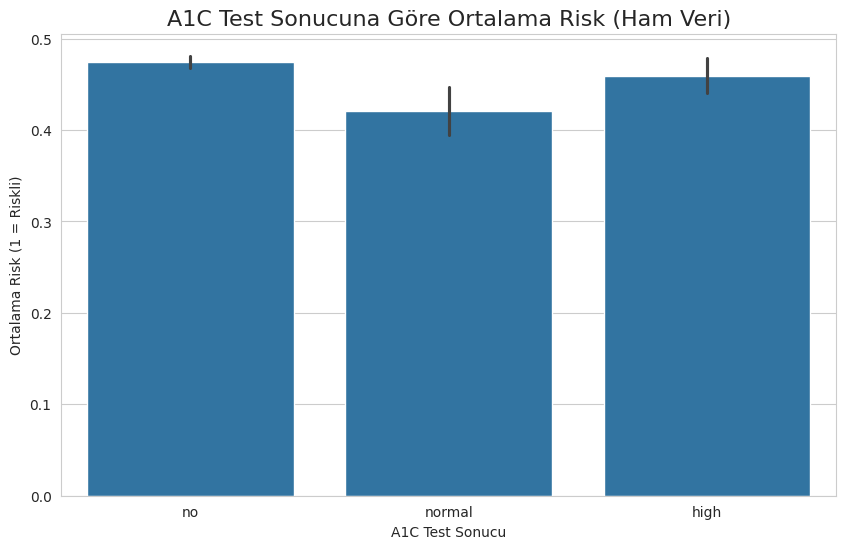

In [ ]:
# A1Ctest için mantıklı sıra
test_order = ['no', 'normal', 'high']

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='A1Ctest', y='target', order=test_order)
plt.title('A1C Test Sonucuna Göre Ortalama Risk (Ham Veri)', fontsize=16)
plt.xlabel('A1C Test Sonucu')
plt.ylabel('Ortalama Risk (1 = Riskli)')
plt.show()

In [ ]:
# 'diag_1', 'diag_2', veya 'diag_3' sütunlarından herhangi birinde 'Missing' olan satırları
# veri setimizden çıkaralım.

print(f"Temizlikten önceki satır sayısı: {len(df)}")
print("---")

# 'Missing' DEĞİLSE (!) satırları tut
df_clean = df[
    (df['diag_1'] != 'Missing') &
    (df['diag_2'] != 'Missing') &
    (df['diag_3'] != 'Missing')
].copy()
# .copy() eklemek, zincirleme atamalarda oluşan 'SettingWithCopyWarning' uyarısını engeller.

print(f"Temizlikten sonraki satır sayısı: {len(df_clean)}")
print(f"Toplam {len(df) - len(df_clean)} satır 'Missing' içerdiği için çıkarıldı.")

# Artık ana DataFrame'imiz temiz olan 'df_clean' olabilir
df = df_clean

Temizlikten önceki satır sayısı: 25000
---
Temizlikten sonraki satır sayısı: 24779
Toplam 221 satır 'Missing' içerdiği için çıkarıldı.


In [ ]:
# 1. 'age' sütunundaki aralıkları orta noktalarına map'leyen bir sözlük (dictionary) oluşturalım
age_map = {
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}

# 2. 'map' fonksiyonunu kullanarak 'age' sütununu bu yeni değerlerle güncelleyelim
df['age'] = df['age'].map(age_map)

# 3. Sonucu kontrol edelim
print("\n--- 'age' Sütunu Dönüşüm Sonrası ---")
print(df['age'].value_counts())
print("\nArtık 'age' sütununun veri tipi:")
print(df['age'].dtype)


--- 'age' Sütunu Dönüşüm Sonrası ---
age
75    6796
65    5865
85    4484
55    4404
45    2482
95     748
Name: count, dtype: int64

Artık 'age' sütununun veri tipi:
int64


In [ ]:
# 'change' ve 'diabetes_med' sütunlarını 1/0'a dönüştürme
df['change'] = df['change'].map({'yes': 1, 'no': 0})
df['diabetes_med'] = df['diabetes_med'].map({'yes': 1, 'no': 0})

print("--- 'change' ve 'diabetes_med' dönüştürüldü ---")
print(df['change'].value_counts())

--- 'change' ve 'diabetes_med' dönüştürüldü ---
change
0    13370
1    11409
Name: count, dtype: int64


In [ ]:
# 'glucose_test' ve 'A1Ctest' sütunlarını sıralı sayılara dönüştürme
# (Değerlerin tam olarak 'no', 'normal', 'high' olduğunu varsayarak)
df['glucose_test'] = df['glucose_test'].map({'no': 0, 'normal': 1, 'high': 2})
df['A1Ctest'] = df['A1Ctest'].map({'no': 0, 'normal': 1, 'high': 2})

print("\n--- 'glucose_test' ve 'A1Ctest' dönüştürüldü ---")
print(df['A1Ctest'].value_counts())


--- 'glucose_test' ve 'A1Ctest' dönüştürüldü ---
A1Ctest
0    20753
2     2799
1     1227
Name: count, dtype: int64


In [ ]:
# OHE uygulanacak sütunların listesi
cols_to_encode = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3']

print(f"\n--- OHE Öncesi Sütun Sayısı: {len(df.columns)} ---")

# 'get_dummies' ile OHE işlemini yapalım
# 'drop_first=True' kullanarak 'dummy variable trap' (kukla değişken tuzağı)
# probleminden kaçınabiliriz, ama bu Random Forest için zorunlu değil.
# Şimdilik basit tutalım.
df = pd.get_dummies(df, columns=cols_to_encode)

print(f"--- OHE Sonrası Sütun Sayısı: {len(df.columns)} ---")
print("Yeni oluşturulan sütunlardan bazıları:")
print(df.columns[-10:]) # En son eklenen 10 sütunu göster

# Başarıyla yapıldığını görmek için veriye tekrar bakalım
display(df.head())


--- OHE Öncesi Sütun Sayısı: 18 ---
--- OHE Sonrası Sütun Sayısı: 42 ---
Yeni oluşturulan sütunlardan bazıları:
Index(['diag_2_Musculoskeletal', 'diag_2_Other', 'diag_2_Respiratory',
       'diag_3_Circulatory', 'diag_3_Diabetes', 'diag_3_Digestive',
       'diag_3_Injury', 'diag_3_Musculoskeletal', 'diag_3_Other',
       'diag_3_Respiratory'],
      dtype='object')


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,glucose_test,A1Ctest,...,diag_2_Musculoskeletal,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory
0,75,8,72,1,18,2,0,0,0,0,...,False,False,True,False,False,False,False,False,True,False
1,75,3,34,2,13,0,0,0,0,0,...,False,True,False,False,False,False,False,False,True,False
2,55,5,45,0,18,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False
3,75,2,36,0,12,1,0,0,0,0,...,False,True,False,False,True,False,False,False,False,False
4,65,1,42,0,7,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True


In [43]:
# --- Adım 5: Özellik Mühendisliği (Feature Engineering) ---

# FİKİR 1: "Kırılganlık Skoru" (Toplam Sistem Kullanımı)
# Neden?: 'n_outpatient', 'n_inpatient' ve 'n_emergency' sütunları, hastanın
# geçmişteki sağlık sistemi kullanımını ayrı ayrı gösterir. Bu üçünü toplamak,
# bize hastanın genel "kırılganlığını" veya "sistem kullanım yoğunluğunu"
# gösteren tek bir güçlü skor (total_prior_visits) verir.

df['total_prior_visits'] = df['n_outpatient'] + df['n_inpatient'] + df['n_emergency']



In [44]:
# FİKİR 2: "Yatış Yoğunluğu" (Günlük İlaç Sayısı)
# Neden?: 10 günde 20 ilaç alan bir hasta ile 2 günde 20 ilaç alan bir hasta
# aynı değildir. İkinci hastanın "yatış yoğunluğu" çok daha yüksektir.
# Bu yeni özellik (meds_per_day), modelin "kısa sürede yoğun tedavi"
# gören yüksek riskli hastaları yakalamasına yardımcı olur.

df['meds_per_day'] = df['n_medications'] / df['time_in_hospital']



In [45]:
# FİKİR 3: "Diyabet Karmaşıklık Skoru"
# Neden?: Sadece test sonuçlarına bakmak (A1Ctest, glucose_test) eksik kalır.
# Asıl risk, halihazırda diyabet ilacı (diabetes_med) kullanan VE bu ilaçlarda
# değişiklik (change) yapılan BİR HASTANIN testlerinin HALA YÜKSEK çıkmasıdır.
# Bu kompozit skor, bu dört faktörü birleştirir.
# Yüksek skor (örn: 6) = "Tedaviye rağmen durumu yönetilemeyen, en yüksek riskli hasta" demektir.
df['diabetes_complexity_score'] = df['A1Ctest'] + df['glucose_test'] + df['diabetes_med'] + df['change']


In [46]:
print(f"Özellik mühendisliği sonrası sütun sayısı: {len(df.columns)}")
print("\nYeni oluşturulan özellikler (son 3 sütun):")

# Yeni oluşturduğumuz sütunları ve verinin son halini görelim
display(df.iloc[:, -10:].head())

Özellik mühendisliği sonrası sütun sayısı: 45

Yeni oluşturulan özellikler (son 3 sütun):


,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,total_prior_visits,meds_per_day,diabetes_complexity_score
0,False,False,False,False,False,True,False,2,2.250000,1
1,False,False,False,False,False,True,False,0,4.333333,1
2,True,False,False,False,False,False,False,0,3.600000,2
3,False,True,False,False,False,False,False,1,6.000000,2
4,False,False,False,False,False,False,True,0,7.000000,1


In [55]:
from sklearn.model_selection import train_test_split

print("--- Adım 6.1 & 6.2: Veri Ayırma ve Bölme ---")

# y (hedef) bizim 'target' sütunumuz
y = df['target']

# X (özellikler) 'target' ve 'readmitted' (string) sütunu
# dışındaki tüm değişkenler
try:
    X = df.drop(['target', 'readmitted'], axis=1)
    print("X matrisi oluşturuldu: 'target' ve 'readmitted' sütunları çıkarıldı.")
except KeyError:

    print("X matrisi oluşturuldu: Sadece 'target' sütunu çıkarıldı.")
    X = df.drop('target', axis=1)

print(f"Özellik matrisi X'in boyutu: {X.shape}")
print(f"Hedef vektörü y'nin boyutu: {y.shape}")
print("---")

# Veriyi ayırıyoruz (stratify=y ile dengeyi koruyarak)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Veri setleri başarıyla EĞİTİM (train) ve TEST olarak ayrıldı!")
print(f"X_train boyutu: {X_train.shape}, X_test boyutu: {X_test.shape}")
print(f"y_train '1' (Riskli) oranı: {y_train.mean():.2f}")
print(f"y_test '1' (Riskli) oranı:  {y_test.mean():.2f}")

--- Adım 6.1 & 6.2: Veri Ayırma ve Bölme ---
X matrisi oluşturuldu: 'target' ve 'readmitted' sütunları çıkarıldı.
Özellik matrisi X'in boyutu: (24779, 43)
Hedef vektörü y'nin boyutu: (24779,)
---
Veri setleri başarıyla EĞİTİM (train) ve TEST olarak ayrıldı!
X_train boyutu: (19823, 43), X_test boyutu: (4956, 43)
y_train '1' (Riskli) oranı: 0.47
y_test '1' (Riskli) oranı:  0.47


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

print("\n--- Adım 6.3: Veri Ölçeklendirme ---")

# 1. Ölçeklendirilmesi gereken (Sayısal/Sürekli) sütunları belirleyelim
numeric_features = [
    'age',
    'time_in_hospital',
    'n_lab_procedures',
    'n_procedures',
    'n_medications',
    'n_outpatient',
    'n_inpatient',
    'n_emergency',
    'glucose_test', # (0,1,2 - ordinal)
    'A1Ctest',      # (0,1,2 - ordinal)
    'total_prior_visits',
    'meds_per_day',
    'diabetes_complexity_score'
]

# 2. ColumnTransformer'ı Kuralım
# 'scaler': numeric_features listesindeki sütunlara StandardScaler uygula
# 'remainder='passthrough'': Geri kalan (OHE) sütunlarına dokunma
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

# 3. Scaler'ı SADECE X_train ile "öğren" (fit) ve X_train'i "dönüştür" (transform)
X_train_scaled = preprocessor.fit_transform(X_train)

# 4. Öğrendiğin (fit ettiğin) scaler ile X_test'i "dönüştür" (transform)
X_test_scaled = preprocessor.transform(X_test)

print("Veri başarıyla ölçeklendirildi.")
print(f"Ölçeklenmiş X_train_scaled boyutu: {X_train_scaled.shape}")


--- Adım 6.3: Veri Ölçeklendirme ---
Veri başarıyla ölçeklendirildi.
Ölçeklenmiş X_train_scaled boyutu: (19823, 43)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

print("\n--- Adım 6.4 & 6.5: Temel Model (Lojistik Regresyon) ---")

print("Temel model (Lojistik Regresyon) eğitiliyor...")

# Modeli kuruyoruz
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Modeli ÖLÇEKLENMİŞ EĞİTİM VERİSİ ile "fit" ediyoruz
log_reg.fit(X_train_scaled, y_train)

print("Model başarıyla eğitildi.")

# --- Model Değerlendirmesi ---
print("\nModel şimdi ÖLÇEKLENMİŞ TEST VERİSİ üzerinde değerlendiriliyor...")
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Skorları hesaplayalım
accuracy = accuracy_score(y_test, y_pred_log_reg)
roc_auc = roc_auc_score(y_test, y_pred_log_reg) # ROC-AUC
f1 = f1_score(y_test, y_pred_log_reg) # '1' (Riskli) sınıfı için F1-Skoru

print("\n--- Lojistik Regresyon Sonuçları ---")
print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"ROC-AUC Skoru: {roc_auc:.4f}")
print(f"F1 Skoru ('1' Sınıfı): {f1:.4f}")

# Detaylı Sınıflandırma Raporu (Precision, Recall, F1)
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred_log_reg))

# Karmaşıklık Matrisi
print("\n--- Karmaşıklık Matrisi (Confusion Matrix) ---")
print(confusion_matrix(y_test, y_pred_log_reg))


--- Adım 6.4 & 6.5: Temel Model (Lojistik Regresyon) ---
Temel model (Lojistik Regresyon) eğitiliyor...
Model başarıyla eğitildi.

Model şimdi ÖLÇEKLENMİŞ TEST VERİSİ üzerinde değerlendiriliyor...

--- Lojistik Regresyon Sonuçları ---
Doğruluk (Accuracy): 0.6142
ROC-AUC Skoru: 0.6034
F1 Skoru ('1' Sınıfı): 0.5026

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

           0       0.60      0.79      0.68      2619
           1       0.64      0.41      0.50      2337

    accuracy                           0.61      4956
   macro avg       0.62      0.60      0.59      4956
weighted avg       0.62      0.61      0.60      4956


--- Karmaşıklık Matrisi (Confusion Matrix) ---
[[2078  541]
 [1371  966]]


Lojistik Regregresyon ile %61.4 doğruluk elde ettik.

Ancak asıl odak noktamız olan 'Riskli' (1) sınıfı için Recall skoru %41'de kaldı. Modelimiz, hastaneye geri dönen her 100 riskli hastadan 59'unu TESPİT EDEMEDİ (Toplam 1371 "False Negative").

Bu temel model, riski yakalamada yetersiz kaldı.

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# --- Adım 6.7: Random Forest Eğitimi ---

print("Random Forest eğitiliyor...")
print("NOT: Ölçeklendirilmemiş (unscaled) X_train verisi kullanılıyor...")

# Modeli kuruyoruz.
# n_estimators=100 -> 100 adet 'karar ağacı' kullan (genel standart)
# random_state=42 -> Tekrarlanabilirlik için
# n_jobs=-1 -> Colab'daki tüm işlemcileri kullanarak eğitimi hızlandır
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Modeli ÖLÇEKLENDİRİLMEMİŞ EĞİTİM VERİSİ ile "fit" ediyoruz
# (X_train_scaled DEĞİL, X_train)
rf_model.fit(X_train, y_train)

print("Model başarıyla eğitildi.")

# --- Adım 6.8: Model Değerlendirmesi ---

print("\nModel şimdi ÖLÇEKLENDİRİLMEMİŞ TEST VERİSİ üzerinde değerlendiriliyor...")
# TAHMİN (prediction) alıyoruz
y_pred_rf = rf_model.predict(X_test)

# Skorları hesaplayalım
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf) # '1' (Riskli) sınıfı için F1-Skoru

print("\n--- Random Forest Sonuçları ---")
print(f"Doğruluk (Accuracy): {accuracy_rf:.4f}")
print(f"ROC-AUC Skoru: {roc_auc_rf:.4f}")
print(f"F1 Skoru ('1' Sınıfı): {f1_rf:.4f}")

# Detaylı Sınıflandırma Raporu (Precision, Recall, F1)
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred_rf))

# Karmaşıklık Matrisi
print("\n--- Karmaşıklık Matrisi (Confusion Matrix) ---")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest eğitiliyor...
NOT: Ölçeklendirilmemiş (unscaled) X_train verisi kullanılıyor...
Model başarıyla eğitildi.

Model şimdi ÖLÇEKLENDİRİLMEMİŞ TEST VERİSİ üzerinde değerlendiriliyor...

--- Random Forest Sonuçları ---
Doğruluk (Accuracy): 0.6090
ROC-AUC Skoru: 0.6039
F1 Skoru ('1' Sınıfı): 0.5541

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

           0       0.62      0.69      0.65      2619
           1       0.60      0.52      0.55      2337

    accuracy                           0.61      4956
   macro avg       0.61      0.60      0.60      4956
weighted avg       0.61      0.61      0.61      4956


--- Karmaşıklık Matrisi (Confusion Matrix) ---
[[1814  805]
 [1133 1204]]


--- Adım 7: Model Yorumlama (Feature Importance) ---
Modelin En Önemli Gördüğü 15 Risk Faktörü:
n_lab_procedures             0.122675
meds_per_day                 0.113923
n_medications                0.103344
time_in_hospital             0.068359
age                          0.058968
n_procedures                 0.050700
total_prior_visits           0.041669
n_inpatient                  0.034895
diabetes_complexity_score    0.032539
diag_2_Other                 0.018383
diag_2_Circulatory           0.018020
diag_3_Other                 0.017763
diag_3_Circulatory           0.017336
medical_specialty_Missing    0.017313
n_outpatient                 0.016851
dtype: float64

--- Görselleştirme Hazırlanıyor... ---


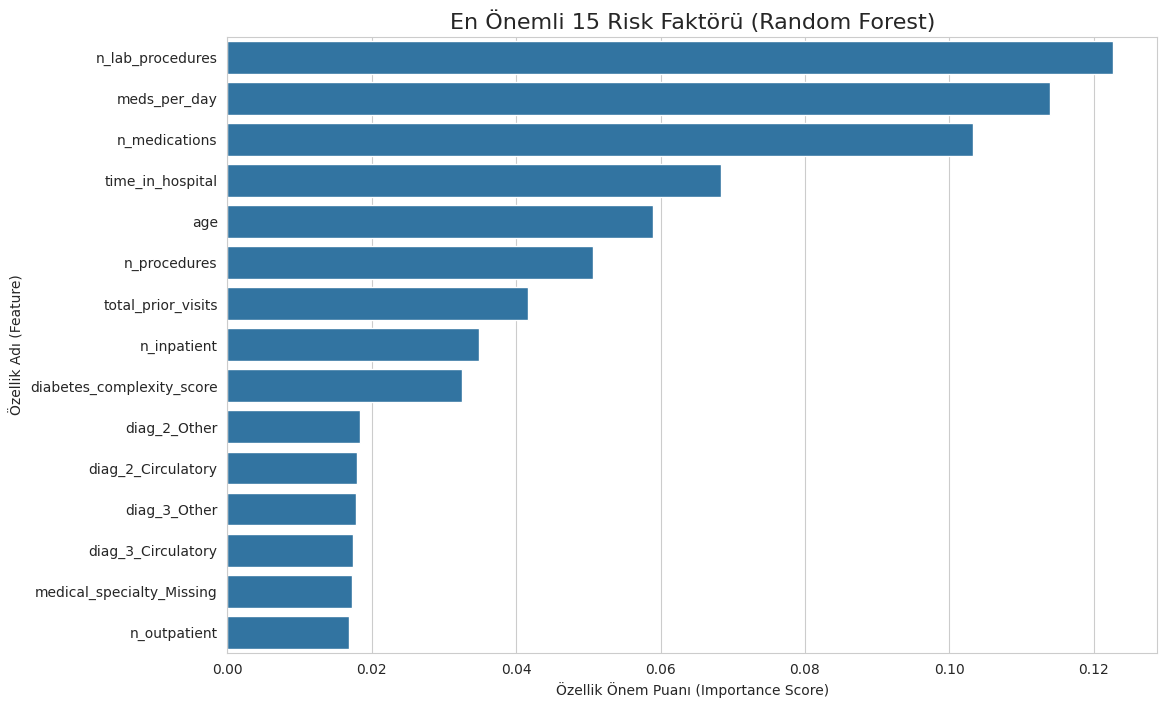

In [59]:
print("--- Adım 7: Model Yorumlama (Feature Importance) ---")

# 1. Özellik İsimlerini ve Puanlarını Birleştirelim
# Modelin 'feature_importances_' listesini alıyoruz
# İndeks olarak da modelin öğrendiği Orijinal X_train sütun isimlerini veriyoruz
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# 2. En Önemlileri Görmek İçin Puanları Sıralayalım
sorted_importances = feature_importances.sort_values(ascending=False)

# 3. En önemli 15 özelliği ekrana yazdıralım
print("Modelin En Önemli Gördüğü 15 Risk Faktörü:")
print(sorted_importances.head(15))

print("\n--- Görselleştirme Hazırlanıyor... ---")

# 4. En Önemli 15 Özelliği GÖRSELLEŞTİRELİM (Portföy için harika!)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=sorted_importances.head(15),
    y=sorted_importances.head(15).index
)
plt.title('En Önemli 15 Risk Faktörü (Random Forest)', fontsize=16)
plt.xlabel('Özellik Önem Puanı (Importance Score)')
plt.ylabel('Özellik Adı (Feature)')
plt.show()

Bu projede, 10 yıllık hasta veriseti kullanılarak, taburcu olan bir hastanın hastaneye tekrar yatma olasılığını tahmin eden bir makine öğrenmesi modeli geliştirilmiştir.

Temel amaç, sağlık sistemlerinin "riskli" hastaları proaktif olarak tespit etmesini sağlayarak kaynakları daha verimli kullanmasına ve önlenebilir yatışları azaltmasına yardımcı olacak **kanıta dayalı bir politika aracı** oluşturmaktır.


**Ana Adımlar ve Metodoloji**

**Veri Temizleme: **'medical_specialty' gibi sütunlardaki 'Missing' (Eksik) değerler bir "hata" olarak silinmek yerine, modelin öğrenmesi için stratejik bir kategori olarak korundu. age gibi aralıklı veriler, sıralı sayısallara ([70-80) -> 75) dönüştürüldü.

**Özellik Mühendisliği:** Modelin karmaşık ilişkileri yakalayabilmesi için alan bilgisine dayalı yeni özellikler türetildi. En önemlileri:

* meds_per_day (Yatış Yoğunluğu): Hastanede kalış süresine oranla günlük ilaç sayısını ölçer.

* total_prior_visits (Kırılganlık Skoru): Hastanın geçmişteki toplam sistem (acil, ayakta, yatan) kullanımını özetler.


**Modelleme:** İki farklı model karşılaştırıldı:

Lojistik Regresyon (Baseline): Yorumlanabilir temel model.

Random Forest (Şampiyon Model): Karmaşık ilişkileri yakalamak için daha güçlü bir model.

Temel Bulgular: Model Karşılaştırması

Projemizdeki asıl kritik başarı metriği, "riskli" (1) olarak etiketlenen hastalar için Recall (Duyarlılık), yani gerçekten riskli olan hastaların ne kadarını yakalayabildiğimizdi.


**Sonuç:** Lojistik Regresyon, riskli hastaların yarısından fazlasını (%59) gözden kaçırdı. Random Forest modelimiz, Recall skorunu %41'den %52'ye çıkararak, Lojistik Regresyon'un kaçırdığı 238 yüksek riskli hastayı daha doğru tespit etti.


**Politika Önerisi:** En Önemli Risk Faktörleri

Random Forest modelinin "Özellik Önem (Feature Importance)" analizi, riskin en büyük belirleyicisinin basitçe "diyabet" olmadığını, hastanın "vaka karmaşıklığı" olduğunu ortaya koydu.


**En Önemli 5 Risk Faktörü:**

* n_lab_procedures (Yapılan Laboratuvar Testi Sayısı)

* meds_per_day (Bizim oluşturduğumuz Yatış Yoğunluğu özelliği!)

* n_medications (Toplam İlaç Sayısı)

* time_in_hospital (Hastanede Kalış Süresi)

* age (Yaş)


**Eylem Önerisi:** Sağlık kaynakları (evde bakım, telefonla takip vb.), sadece 'yaşlı' veya 'diyabetli' hastalara değil; yüksek sayıda laboratuvar testi, yoğun ilaç tedavisi ve karmaşık bir yatış süreci geçiren hastalara öncelikli olarak odaklanmalıdır.